In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('dark_background')
import matplotlib.animation as animation
from matplotlib.ticker import LogFormatterSciNotation


# Part A Computation

In [4]:
#double check before present, CGS

h = 6.63e-27  #plank (erg·s)
q = 4.8e-10   #elem. charge (statC)
m = 9.11e-28  #e- mass(g)
c = 3e10      #speed of light (cm/s)
B = 0.1       #mag field strength (G) (0.1G)
sin_alpha = 1 / np.sqrt(3)  # average over pitch angle

mc2 = 0.511e6 * 1.602e-12  #erg
gamma = 10**4  #given Lorentz factor

#calculate ratio in CGS

numerical_ratio = (3/2) * (h * q * B / (2 * np.pi)) * (gamma**3 / (m**2 * c**3)) * sin_alpha

#display in scientific notation
print(f"Numerical ratio: {numerical_ratio:.2e}")

Numerical ratio: 1.96e-03


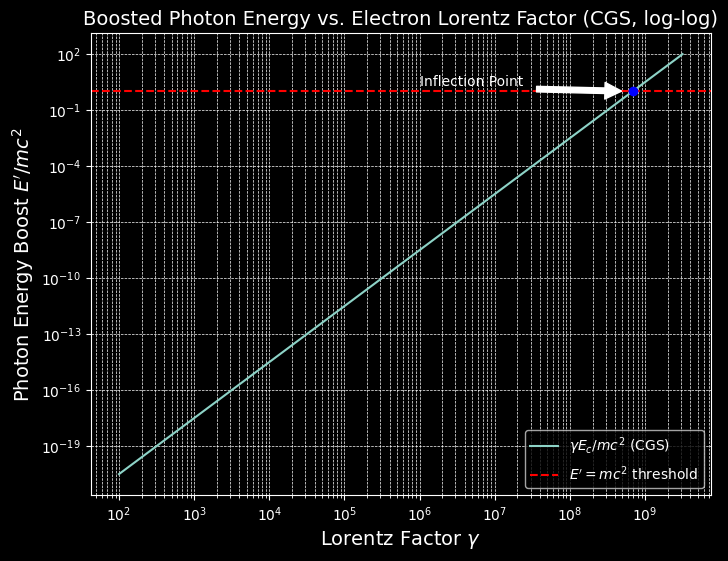

In [5]:
#solved the problem, but lets look how the solution varies as gamma changes
#compute E_c (which is synch. photon energy in lab frame)
def compute_Ec_cgs(gamma, B_field):
    return (3/2) * (h * q * B_field / (2 * np.pi * m * c)) * gamma**2 * sin_alpha

#E'/mc**2 ratio
def compute_ratio_cgs(gamma, B_field):
    Ec = compute_Ec_cgs(gamma, B_field)
    mc2 = 0.511e6  #e- rest energy in eV
    return (gamma * Ec) / mc2

#np range of lorentz factors
gamma_values = np.logspace(2, 9.5, 10000) #probably too many points, but all gucci
ratios = compute_ratio_cgs(gamma_values, B)

#find crossing point
crossing_gamma = np.interp(1, ratios, gamma_values)

#lin looked bad, plot in loglog scale
plt.figure(figsize=(8, 6))
plt.loglog(gamma_values, ratios, label=r'$\gamma E_c / mc^2$ (CGS)')
plt.axhline(1, color='red', linestyle='--', label=r'$E^\prime = mc^2$ threshold')

plt.xlabel(r'Lorentz Factor $\gamma$', fontsize=14)
plt.ylabel(r'Photon Energy Boost $E^\prime / mc^2$', fontsize=14)
plt.title(r'Boosted Photon Energy vs. Electron Lorentz Factor (CGS, log-log)', fontsize=14)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.scatter(crossing_gamma, 1, color='blue', zorder=5)  # Mark the crossing point
#call out inflection point
plt.annotate('Inflection Point', xy=(crossing_gamma, 1), xytext=(1e6, 2),
             arrowprops=dict(facecolor='white', shrink=0.1))
plt.savefig('1. Photon Energy vs Gamma.png', dpi=600)
plt.show()

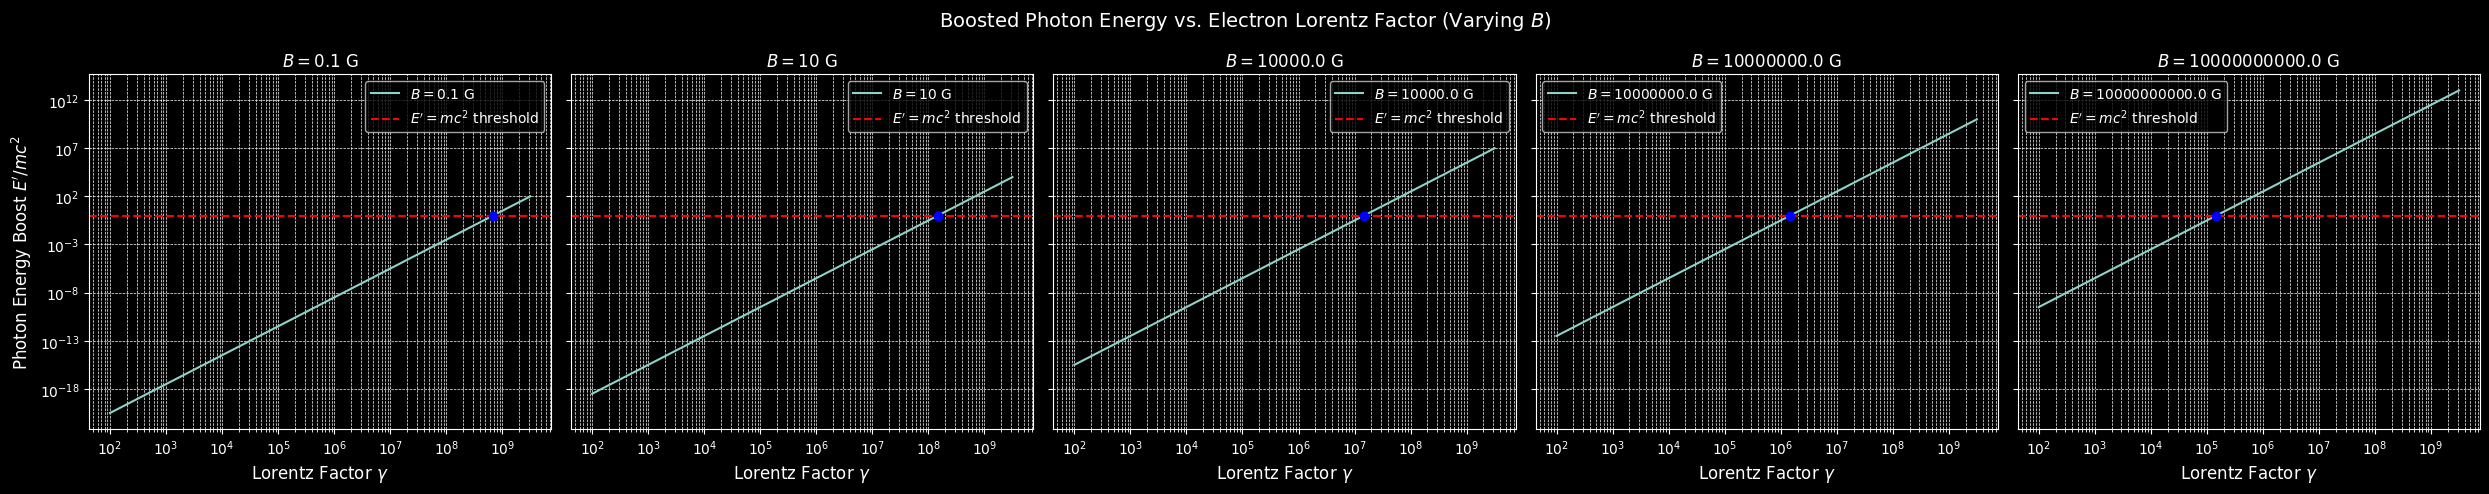

In [6]:
#follow this up with subplot of varying B, we will go from 0.01G to 1e9G or so
#gen subplots different strengths
def plot_boosted_energy_vs_gamma_varying_B(gamma_values, B_values):
    fig, axes = plt.subplots(1, len(B_values), figsize=(5 * len(B_values), 5), sharey=True)

    for i, B in enumerate(B_values):
        ratios = compute_ratio_cgs(gamma_values, B)
        crossing_gamma = np.interp(1, ratios, gamma_values)

        axes[i].loglog(gamma_values, ratios, label=rf'$B = {B}$ G')
        axes[i].axhline(1, color='red', linestyle='--', label=r'$E^\prime = mc^2$ threshold')
        axes[i].scatter(crossing_gamma, 1, color='blue', zorder=5)
        axes[i].set_xlabel(r'Lorentz Factor $\gamma$', fontsize=12)
        if i == 0:
            axes[i].set_ylabel(r'Photon Energy Boost $E^\prime / mc^2$', fontsize=12)
        axes[i].set_title(rf'$B = {B}$ G', fontsize=12)
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
        axes[i].legend()

    plt.suptitle(r'Boosted Photon Energy vs. Electron Lorentz Factor (Varying $B$)', fontsize=14)
    plt.tight_layout()
    plt.savefig('2. Boosted Photons with Different B Strength.png', dpi=600)
    plt.show()

B_values = [10e-2, 10, 10e3, 10e6, 10e9]#can tweak this for best representation
plot_boosted_energy_vs_gamma_varying_B(gamma_values, B_values)


In [7]:
import concurrent.futures #so slow without multithreading, will fix later



#ani doesn't look good, will remove after tweaking to find right value
DURATION =20 #in sec
FPS = 30  #caveman, more is better but longer
B_MIN = 0.01  #start gauss
B_MAX = 1e9  #end gauss
BOUNCE = True  #built in both loop and bounch

#ani of plot varying over time as B changes
def animate_boosted_energy_vs_gamma(gamma_values, B_min=B_MIN, B_max=B_MAX, duration=DURATION, fps=FPS, bounce=BOUNCE):
    B_values = np.linspace(B_min, B_max, num=duration * fps * 2)
    if bounce:
        B_values = np.concatenate([B_values, B_values[::-1]])  #reverse for bounce

    fig, ax = plt.subplots(figsize=(7, 5))

    def update(frame):
        ax.clear()
        B = B_values[frame]
        ratios = compute_ratio_cgs(gamma_values, B)
        crossing_gamma = np.interp(1, ratios, gamma_values)

        ax.loglog(gamma_values, ratios, label=rf'$B = {B:.2e}$ G')
        ax.axhline(1, color='red', linestyle='--', label=r'$E^\prime = mc^2$ threshold')
        ax.scatter(crossing_gamma, 1, color='blue', zorder=5)
        ax.set_xlabel(r'Lorentz Factor $\gamma$', fontsize=12)
        ax.set_ylabel(r'Photon Energy Boost $E^\prime / mc^2$', fontsize=12)
        ax.set_title(rf'Boosted Photon Energy vs. Electron Lorentz Factor ($B = {B:.2e}$ G)', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()
        ax.yaxis.set_major_formatter(LogFormatterSciNotation())

    ani = animation.FuncAnimation(fig, update, frames=len(B_values), interval=10 / fps)
    gif_path = '3. Boosted Energy Animation.gif'

    def save_animation():
        ani.save(gif_path, writer='pillow', fps=fps)
        plt.close(fig)

    #threading for concurrent execution
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(save_animation)
        return future

#call, can restate gamma from previous plot or just set it differently here
gamma_values = np.logspace(2, 9.5, 500)
animate_boosted_energy_vs_gamma(gamma_values)


<Future at 0x76023fbe8ef0 state=finished returned NoneType>

# Numerical Computation - Part B

In [8]:
#redo cgs
k_B = 1.38e-16  # erg/K (google says this is kb in cgs)
T_CMB = 3  #K (temp of CMB)
mc2 = 0.511e6 * 1.602e-12  #erg electron rm in cgs

#calculate CMB photon energy in CGS
E_CMB = 2.8 * k_B * T_CMB  #erg

#transform to electron rest frame by 1 factor of gamma
E_prime = gamma * E_CMB  #transform

#compute ratio
ratio_cmb = E_prime / mc2

#display in scientific notation
print(f"Ratio: {ratio_cmb:.3e}", 'unitless')

Ratio: 1.416e-05 unitless
